## Functional preference profiles

Now my favorite part, and I think the most unique aspect of our paper.

For each region in the clustering analysis, we're going to determine how well we can classify studies that activated the region, versus those that did not, on the basis of semantic topics that describe the psychological states in each study. 

Using the RegionalClassifier class included in this repo, we can perform this analysis on any given clustering image. I've also included some functons to easily make polar plots to visualize which topics were most strongly associated with any given region

### Classification

In [1]:
# Load a neurosynth dataset. If you generate your own dataset, you can try this with fewer or greater number of topics
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("data/neurosynth_60_0.4.pkl")

In [2]:
from sklearn.naive_bayes import GaussianNB
from classification import RegionalClassifier
from sklearn.metrics import roc_auc_score

We used Gaussian naive Bayes for classificaiton, and extract log odds ratios for each topic for each region to estimate how strongly each psychological state indicated that a given region was active. Note: If you wish to use a different classifier, you must specify a `importance_function` to extract the appropriate values from the classifiers, as these vary for each algorithm. 

In [3]:
# Instantiate a RegionalClassifier for your image and classify
clf = RegionalClassifier(dataset, 'images/cluster_labels_k3.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
100%|██████████| 3/3 [00:00<00:00, 8405.42it/s]

Classifying...


We can take a look at various aspects of the classification performance such as the classification performance for each region (in this case ROC area under the curve):

In [4]:
clf.class_score

array([ 0.63538912,  0.6304816 ,  0.67899716])

### Visualization with polar plots

I've included a listing of the topics used in the manuscript, and a set of "nicknames" that I used throughout the manuscript for each topic. This bit of code extracts the nickname (i.e. topic_name) I gave to each topic to help with visualization. You may also use "top_2" to label each topic with the two strongest loading words.

In [4]:
import pandas as pd
word_keys = pd.read_csv("data/topic_keys60-july_cognitive.csv")
word_keys['top_2'] = word_keys['Top words'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')
feature_names = pd.merge(pd.DataFrame(clf.feature_names, columns=['topic_name']), word_keys)['Topic name'].tolist()

To recreate the plots from the publication, we simply extract a pandas formatted table of importances that represent how strongly each topic indicated each region would be active in a study (in this case log odds ratios) using `clf.get_formatted_importances`, ensuring to provide the topic nicknames from above. 

Then, we feed this pandas table into plot_clf_polar, which returns a nice polar plot each each prespecified topic.

In [6]:
from plotting import plot_clf_polar

In [7]:
selected_labels = ['fear', 'reward','gaze','motor','inhibition','WM','conflict','switching', 
                   'pain','decision-making','social', 'episodic memory']

:0: FutureWarning: IPython widgets are experimental and may change in the future.


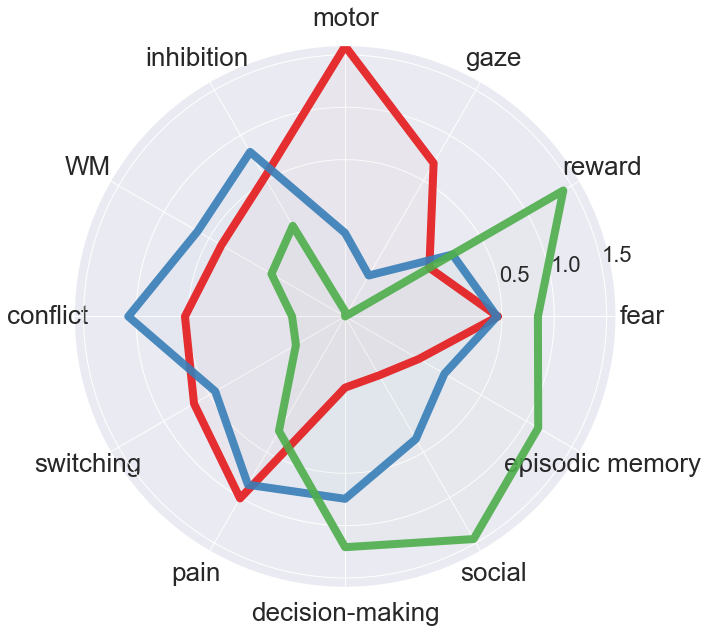

In [8]:
_ = plot_clf_polar(clf.get_formatted_importances(feature_names=feature_names), labels = selected_labels)

We can also ask plot_clf_polar to choose some topics for us. In this case, we're asking for the 4 topics that load most strongly for each region, and specifiying that these topics are reordered to ensure a nice looking visualization. Under the hood, this function uses hierarchical clustering to reorder the topics. See the docstring of `plot_polar` for many more ways to choose topics and automatically order the features.

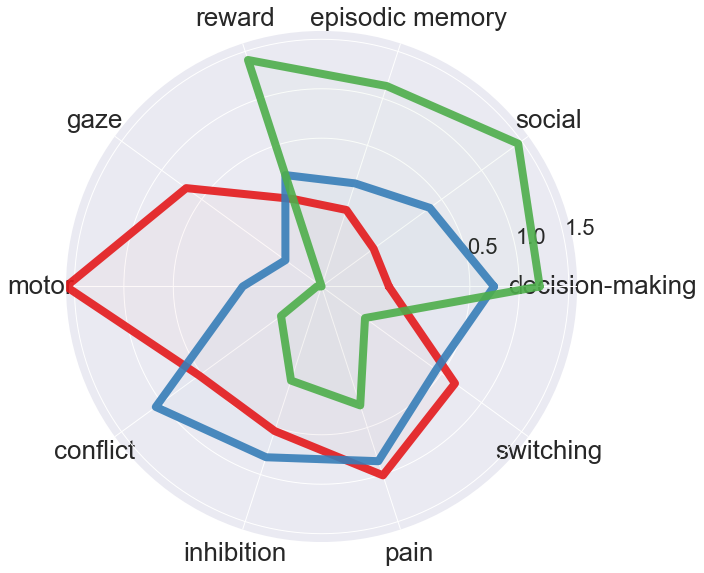

In [9]:
topics = plot_clf_polar(clf.get_formatted_importances(feature_names=feature_names), n_top=4, reorder=True)

In [10]:
## plot_clf_polar also returns the topics it selected as a list, and the data that went into the visualization (for debugging)
topics

(['decision-making',
  'social',
  'episodic memory',
  'reward',
  'gaze',
  'motor',
  'conflict',
  'inhibition',
  'pain',
  'switching'],
 region                  1         2         3
 feature                                      
 decision-making -0.318756  0.743887  1.205991
 social          -0.348924  0.353434  1.457282
 episodic memory -0.185740  0.096783  1.131763
 reward          -0.069206  0.185436  1.408609
 gaze             0.692770 -0.546656 -0.998811
 motor            1.584130 -0.201792 -0.951320
 conflict         0.531437  1.072572 -0.491969
 inhibition       0.537294  0.816339  0.001173
 pain             1.008900  0.858136  0.265164
 switching        0.668114  0.433751 -0.456181)

## k = 9 Classification polar plots
Here's I perform the classification analysis and visualize the results using polar plots for the k = 9 solution, grouping each polar plot by the organization of these clusters into the coarser k = 3 solution

In [11]:
# Instantiate a RegionalClassifier for your image and classify
clf_9 = RegionalClassifier(dataset, 'images/cluster_labels_k9.nii.gz', GaussianNB())
clf_9.classify(scoring=roc_auc_score)

Classifying...
[##########] 100%


For these plots, we have to use `mask = ` to specify which of the 9 regions we want to display in each polar plot. I also use a custom set of nine colors used in the publication

In [12]:
# Here I define the groupings
posterior = [3, 6]
middle = [1, 5, 7, 9]
anterior = [2, 4, 8]

# And load the custom 9 colors
from plotting import nine_colors

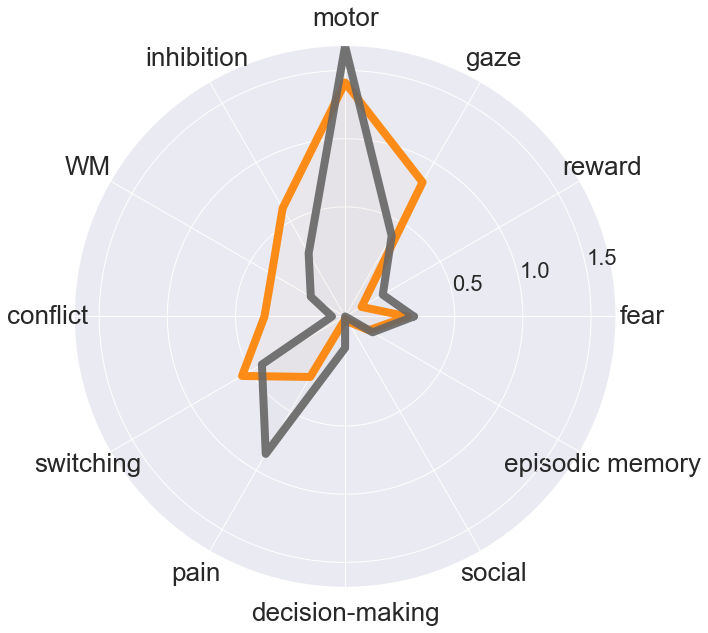

In [15]:
_ = plot_clf_polar(clf_9.get_formatted_importances(feature_names=feature_names), labels = selected_labels,
                  mask = posterior, palette = nine_colors)

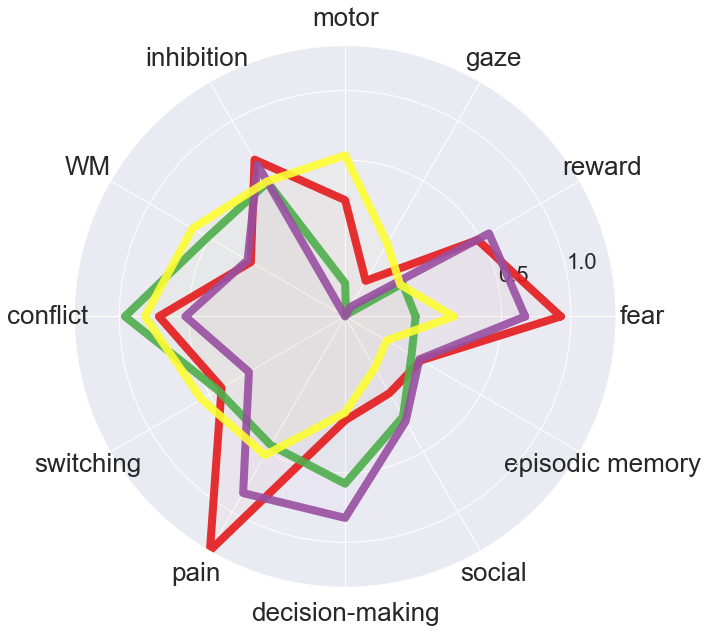

In [16]:
_ = plot_clf_polar(clf_9.get_formatted_importances(feature_names=feature_names), labels = selected_labels,
                  mask = middle, palette = nine_colors)

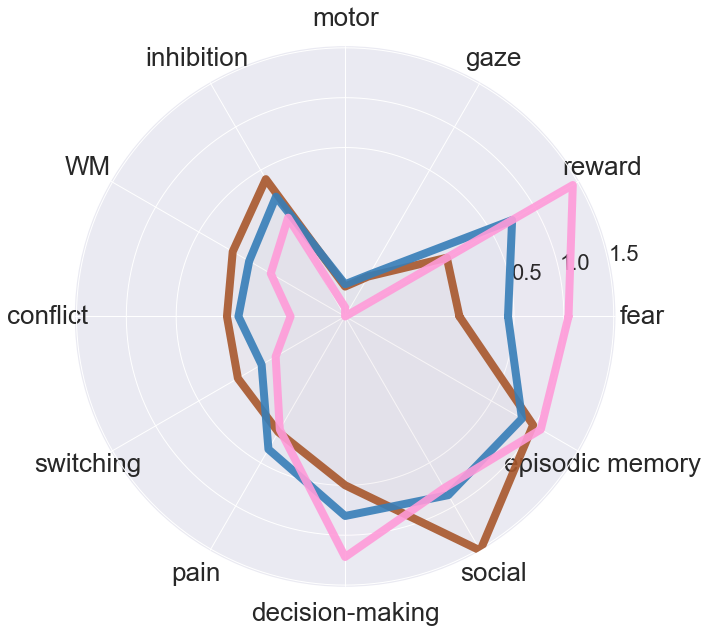

In [17]:
_ = plot_clf_polar(clf_9.get_formatted_importances(feature_names=feature_names), labels = selected_labels,
                  mask = anterior, palette = nine_colors)

And there you have it! I encourage others to use this analysis pipeline on other brain regions they're interested in

TODO:
 - Bootstrapped confidence intervals
 - Permutation significance tests